In [37]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [38]:
df = pd.read_csv('Updated_Drone_Data.csv')

df

,Maximum Principal Elastic Strain (m/m),Equivalent Elastic Strain (m/m),Length (mm),Depth (mm)
0,1.660000e-08,2.170000e-08,403.1,101.0
1,1.490000e-08,1.930000e-08,399.9,100.9
2,1.220000e-08,1.690000e-08,403.0,99.5
3,1.100000e-08,1.450000e-08,397.8,99.7
4,9.810000e-09,1.210000e-08,398.0,99.1
...,...,...,...,...
74,1.900000e-09,7.940000e-09,413.0,76.0
75,4.160000e-09,6.940000e-09,385.0,119.2
76,6.220000e-09,6.070000e-09,410.5,116.3
77,4.400000e-10,7.300000e-09,385.0,97.8


In [39]:
# Scale the 'Maximum Principal Elastic Strain' column by 10^10
df['Maximum Principal Elastic Strain (m/m)'] = df['Maximum Principal Elastic Strain (m/m)'] * 1e10

# Optionally, check the updated values
print(df.head())

   Maximum Principal Elastic Strain (m/m)  Equivalent Elastic Strain (m/m)  \
0                                   166.0                     2.170000e-08   
1                                   149.0                     1.930000e-08   
2                                   122.0                     1.690000e-08   
3                                   110.0                     1.450000e-08   
4                                    98.1                     1.210000e-08   

   Length (mm)  Depth (mm)  
0        403.1       101.0  
1        399.9       100.9  
2        403.0        99.5  
3        397.8        99.7  
4        398.0        99.1  


In [40]:
# Define the hyperparameter space
hyp_space  = [
    Integer(3, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

In [41]:
# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []

    # Perform cross-validation
    for train_idx, val_idx in kfold.split(df[['Length (mm)', 'Depth (mm)']]):
        X_train, X_val = df[['Length (mm)', 'Depth (mm)']].iloc[train_idx], df[['Length (mm)', 'Depth (mm)']].iloc[val_idx]
        y_train, y_val = df[['Maximum Principal Elastic Strain (m/m)']].iloc[train_idx], df[['Maximum Principal Elastic Strain (m/m)']].iloc[val_idx]

        # Standardize the features
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = scaler_x.transform(X_train)
        X_val_scaled = scaler_x.transform(X_val)

        # Train the model
        # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

        # Evaluate the model
        score = model.evaluate(X_val_scaled, y_val, verbose=0)
        scores.append(score)
    
    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=30, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
)

Best hyperparameters:
num_layers: 3
num_units: 50
learning_rate: 0.0028987907296180535
dropout_rate: 0.5
batch_size: 20
epochs: 200


In [42]:
from sklearn.model_selection import train_test_split

train_X = df[['Length (mm)', 'Depth (mm)']].to_numpy()
train_y = df['Maximum Principal Elastic Strain (m/m)'].to_numpy()

# Standardize the initial dataset
scaler_x = StandardScaler().fit(train_X)
X_scaled = scaler_x.transform(train_X)

# #Splits data into training and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, train_y ,test_size=0.20)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12449.4814
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17620.9863
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16654.9375
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18462.2051
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24841.7539
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17624.9512
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11052.5986
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17867.4805
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11842.2363
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39900.1602 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11929.7363
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15879.4922
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23091.3984
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10510.0732
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2

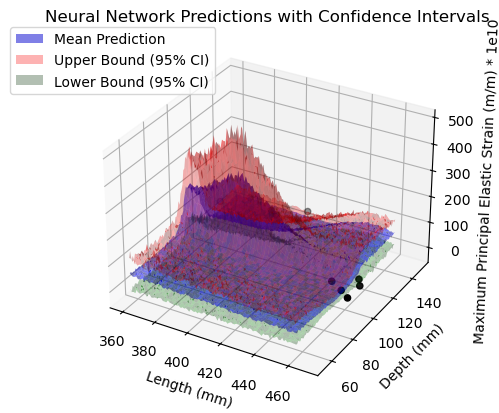

In [43]:
# Train the best model on training set
best_model.fit(X_scaled, train_y, epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Produce Meshgrid of input space
x1_range = np.linspace(360, 460, 100)
x2_range  = np.linspace(54, 150, 100)

x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

x_grid = scaler_x.transform(x_grid)

# Perform MC Dropout predictions for entire meshgrid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

# Define range for inputs
bounds = np.array([[360, 470], [54, 150]])

# Identify top 10 points with highest uncertainty
num_new_points = 10

sampler = qmc.LatinHypercube(d=2)  # LHS in a 2D space
lhs_sample = sampler.random(n=1000)
lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])

lhs_points_scaled = scaler_x.transform(lhs_points)

lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points_scaled)
percentile_threshold = 10 
threshold_value = np.percentile(lhs_mean, percentile_threshold)

# Filter points above the threshold
points_above_threshold = lhs_points[lhs_mean <= threshold_value]

num_new_points = 10
if len(points_above_threshold) > num_new_points:
    selected_indices = np.random.choice(len(points_above_threshold), num_new_points, replace=False)
    selected_points = points_above_threshold[selected_indices]
else:
    selected_points = points_above_threshold

new_points_df = pd.DataFrame(selected_points, columns=['x','y'])

# Ploting mean predictions and confidence intervals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Reshaping predictions back to grid shape
pred_mean_grid = pred_mean.reshape(x1_grid.shape)
pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

# Plot next points for sampling
from scipy.spatial import cKDTree

# Create a KDTree for efficient nearest neighbor lookup in the meshgrid
tree = cKDTree(x_grid)

# Find the indices of the closest points in the meshgrid for the selected points
_, indices = tree.query(selected_points)

# Get the corresponding pred_mean values from the meshgrid and plot next points for observation
selected_mean = pred_mean[indices]
ax.scatter(selected_points[:, 0], selected_points[:, 1], selected_mean, color='black', marker='o', label='Next Sampling Points')

# Plot Labels
ax.set_title('Neural Network Predictions with Confidence Intervals')
ax.set_xlabel('Length (mm)')
ax.set_ylabel('Depth (mm)')
ax.set_zlabel('Maximum Principal Elastic Strain (m/m) * 1e10')

# Legend
legend_elements = [mean_surface, upper_surface, lower_surface]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

In [44]:
selected_points

array([[468.98713725,  87.24780838],
       [454.27506489,  96.1877149 ],
       [469.01854205,  99.10593022],
       [462.72068448,  91.44546162],
       [372.65750616, 144.10209259],
       [408.09708317, 146.4778599 ],
       [465.61234487, 103.95007418],
       [360.44143951, 133.67814321],
       [389.89967517, 138.78563133],
       [394.85605351, 136.14752785]])

In [51]:
new_points_df.rename(columns={'x': 'Length (mm)', 'y': 'Depth (mm)'}, inplace=True)

filename = 'Drone Data New Points.xlsx'
new_points_df.to_excel(filename, index=False)

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_scaled)

# # Calculate regression metrics
mse = mean_squared_error(train_y, y_pred)
mae = mean_absolute_error(train_y, y_pred)
r2 = r2_score(train_y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Squared Error (MSE): 14330.74922272688
Mean Absolute Error (MAE): 45.81607000230235
R² Score: 0.2994943119845782
